It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/RNN/Introduction_to_RNN_Time_Series.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/Introduction_to_RNN_Time_Series.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

#### Import keras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

## Simple Architectures

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In time series forecasting we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [ ]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [ ]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features] 
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [ ]:
model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(timesteps, features))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(10))

model.summary()

## Time Series Analysis

#### Windowing sequences

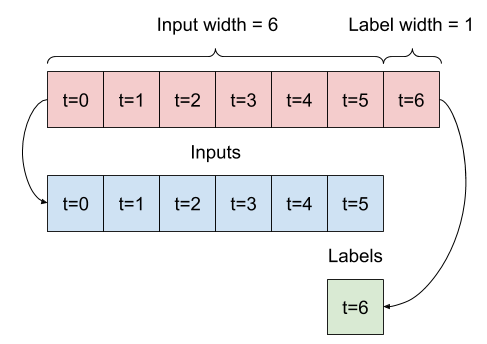

Creates a dataset of sliding windows over a timeseries provided as array with [timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array).



For creating the windows we use [timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

```python
tf.keras.preprocessing.timeseries_dataset_from_array(
    data, targets, sequence_length, sequence_stride=1, sampling_rate=1,
    batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None
)
```

For preprocessing the input we are going to use `prepare_dataset`

In [ ]:
def prepare_dataset(ts, past, future, batch_size):
    start = past + future - 1
    x = ts[:-past + 1]
    y = ts[start:start + len(x)]
    # padding
    y = np.concatenate([y, np.zeros(len(x) - len(y))])
    dataset = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=past,
        batch_size=batch_size,
    )
    return dataset

### Airlines Dataset

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
#df = pd.read_csv('../data/airline-passengers.csv', usecols=[1])
url = 'https://c4science.ch/diffusion/2096/browse/master/input/international-airline-passengers.csv'
df = pd.read_csv(url, usecols=[1], nrows=144)
dataset = df.values  # .flatten()
plt.plot(dataset)
plt.show()

Split in train/test set and scale with  StandardScaler

In [ ]:
split_fraction = 0.75
train_split = int(split_fraction * int(len(dataset)))


from sklearn.preprocessing import StandardScaler
# scale the data
scaler = StandardScaler()
scaler.fit(dataset[:train_split])


dataset_s = scaler.fit_transform(dataset).flatten()
plt.plot(dataset_s)
plt.show()

In [ ]:
# split into train and test sets
train, test = dataset_s[0:train_split], dataset_s[train_split:len(dataset)]
print(len(train), len(test))

In [ ]:
# lenght of sequence for predicting
past = 2
# future steps to predict
future = 1

batch_size = 4
dataset_train = prepare_dataset(train, past, future,
                    batch_size)
dataset_val = prepare_dataset(test, past, future,
                    batch_size)


In [ ]:
for windows, targets in dataset_train:
    print('windows shape: {}'.format(windows.shape))
    print('targets shape: {}'.format(targets.shape))
    for i in range(len(targets)):
        print('window,target: {},{}'.format(windows[i,:].numpy(), targets[i].numpy()))   
    break

In [ ]:
inputs_shape = (past, 1)
inputs = keras.layers.Input(shape=(past,1))
lstm_out_1 = keras.layers.LSTM(32, return_sequences=False)(inputs)
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val
)


In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xticks([])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    x_in = scaler.inverse_transform(x.numpy())
    y_in = scaler.inverse_transform(y.numpy())
    pred = scaler.inverse_transform(model.predict(x))
    show_plot(
        [x_in[0,:], y_in[0], pred.flatten()[0]],
        future,
        "Single Step Prediction",
    )

In [ ]:
# future steps to predict
future = 1
sequence_length = int(past)  # the that steps we use to predict

x = dataset_s[:-past]
# first target oof first window is len(window) + future
y = dataset_s[past:]

batch_size=200
dataset_ts = tf.keras.preprocessing.timeseries_dataset_from_array(
    x, y, sequence_length=past, batch_size=batch_size)
for x, y in dataset_ts:
    x_in = scaler.inverse_transform(x.numpy())
    y_in = scaler.inverse_transform(y.numpy())
    pred = scaler.inverse_transform(model.predict(x))
    
plt.plot(y_in)
plt.plot(pred)
plt.legend(['Real','Prediction'])
plt.show()

## Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [ ]:
from zipfile import ZipFile
import os


uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path, parse_dates =['Date Time'])
df.head()

### Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [ ]:
selected_features_title = ['Pressure', 'Temperature', 'Saturation vapor pressure',
                 'Vapor pressure deficit', 'Specific' 'humidity', 'Airtight', 'Wind speed']
selected_features = ['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)',
"max. wv (m/s)","wd (deg)" ]

### Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (76/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [ ]:
df = df.set_index('Date Time')
## resample by the mean of hour values
df =df.resample('1h').mean().fillna(method='ffill') # 
df.head()

In [ ]:
#Use only important features
df_0 = df.copy()
df = df[selected_features].copy()

In [ ]:
df.values.shape

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [ ]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

### Training and validation datasets



In [ ]:
def prepare_dataset(df, past, future,
                    batch_size, target):
    start = past + future - 1
    x = df.iloc[:-past + 1]
    y = df.iloc[start:start + len(x)][target].values.flatten()
    # padding
    y = np.concatenate([y, np.zeros(len(x) - len(y))])
    dataset = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=past,
        batch_size=batch_size,
    )
    return dataset

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [ ]:
## previous hours to consider
past = 6 
## Number of hours later to predict
future = 12

batch_size = 128


dataset_train = prepare_dataset(train_data, past, future,
                    batch_size, target = 'T (degC)')
dataset_val = prepare_dataset(val_data, past, future,
                    batch_size, target= 'T (degC)')

for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
#dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Training

#### Normalization layer
We can normalize the features with [Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization).

```python
tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, mean=None, variance=None, **kwargs
)
```

```python
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(dataset_train.map(lambda x, y: x))

```



`adapt` computes mean and std of the train data and store them as the layer's weights. `adapt`
 should be called before fit, evaluate, or predict.



In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, mean=None, variance=None
)
norm.adapt(dataset_train.map(lambda x, y: x))

print('Unnormalized row: ', df.iloc[:1].values)
print('Normalized row: ', norm(df.iloc[:1]))
print('Normalized df, mean row: ',norm(df.values).numpy().mean(1))
print('Normalized df, std row: ',np.std(norm(df.values).numpy(), 1))

#### Create the model

In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

num_features =  9
inputs_shape = (past, num_features)

inputs = keras.layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
rnn_out = keras.layers.SimpleRNN(32)(inputs_norm)
outputs = keras.layers.Dense(1)(rnn_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )

In [ ]:
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

#### Question 1:  Change the `keras.layers.SimpleRNN` layer to `keras.layers.LSTM` and to `keras.layers.GRU` and compare the results
You can also set the `recurrent_dropout` parameter

```python
tf.keras.layers.x(
    units,
    dropout=0.0,
    recurrent_dropout=0.0)
```

In [ ]:
num_features = ...
inputs_shape = (past, num_features)


norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
lstm_out = layers...(...)(...)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )
    
    
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

### Feature Engineering

Wind velocity
One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
df['wv (m/s)'] = wv

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
df['max. wv (m/s)'] = max_wv


But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [ ]:
wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:


Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
from datetime import datetime
timestamp_s = df.index.map(datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
df.head()

In [ ]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

In [ ]:
sequence_length = int(past / 1)

dataset_train = prepare_dataset(train_data, past, future,
                    batch_size, target = 'T (degC)')
dataset_val = prepare_dataset(val_data, past, future,
                    batch_size, target= 'T (degC)')

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Question 2:  Use the same model as before and compare the results


In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

num_features = ...
inputs_shape = (past, num_features)

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
## complete the code
lstm_out = layers..(...)(...)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )
    
    
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

### Question 3:  Create a deep model stacking two recurrent layers

In [ ]:
num_features = ...
inputs_shape = (past, num_features)


norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
l_1 = keras.layers.LSTM(..., return_sequences=...)(...)
l_2 = keras.layers.LSTM(..., return_sequences=...)(...)

outputs = keras.layers.Dense(1)(...)


model = keras.Model(inputs=...)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )
    
    
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

### Question 4:  Use `Bidirectional`  layer

```python
layers.Bidirectional(layers.LSTM(64, return_sequences=)
````


In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))


inputs = layers.Input(shape=(..., ...))
inputs_norm = norm(inputs)

## complete the code
l_1 = ...(...)

outputs = keras.layers.Dense(1)(...)


model = keras.Model(inputs=...)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )
    
    
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

### Question 5:  Obtain a good model for predicting the temperature in 24h

Try different architectures and different values for `past`

In [ ]:
future = 24

In [ ]:
past = ...
batch_size = ...
dataset_train = prepare_dataset(train_data, past, future,
                    batch_size, target = 'T (degC)')
dataset_val = prepare_dataset(val_data, past, future,
                    batch_size, target= 'T (degC)')

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))


inputs = layers.Input(shape=(..., ...))
inputs_norm = norm(inputs)


l_1 = keras.layers.LSTM(..., return_sequences=...)(...)
l_2 = keras.layers.LSTM(..., return_sequences=...)(...)

outputs = keras.layers.Dense(1)(...)

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )
    
    
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

## Practice: Cryptocurrency Forecasting

First of all, obtain and pre-process the data from [www.cryptodatadownload.com](www.cryptodatadownload.com)

In [ ]:
# http://www.cryptodatadownload.com/cdd/gemini_{0}USD_1hr.csv
# '../data/gemini_{0}USD_1hr.csv'
def get_coin_df(fpath='../data/gemini_{0}USD_1hr.csv'):
    coins = ['BTC', 'ETH', 'LTC', 'ZEC']
    coins = ['BTC', 'ETH']
    file_path = fpath.format('BTC')
    print(file_path)
    df = pd.read_csv(file_path, parse_dates=['Date'], skiprows=1, skipfooter=1)
    df = df[['Date', 'Open']]
    df = df.set_index('Date')
    df = df.sort_index()
    df = df.rename(columns={'Open': 'BTC'})
    for coin in ['ETH', 'LTC', 'ZEC']:
        coin_path = fpath.format(coin)
        df_coin = pd.read_csv(coin_path,
                              parse_dates=['Date'],
                              skiprows=1,
                              skipfooter=1)
        df_coin = df_coin[['Date', 'Open']]
        df_coin = df_coin.set_index('Date')
        df_coin = df_coin.sort_index()
        df_coin = df_coin.rename(columns={'Open': coin})
        df[coin] = np.nan
        df.loc[df_coin.index, coin] = df_coin.values.flatten()
    return df


df = get_coin_df(
    fpath='http://www.cryptodatadownload.com/cdd/gemini_{0}USD_1hr.csv')
df.tail()

In [ ]:
# df = df.diff()
# df[df.columns] = np.sqrt(df.values)

Lets visualize the scaled values

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = scaler.fit_transform(df)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

In [ ]:
coins = ['BTC', 'ETH', 'LTC', 'ZEC']
for col in coins:
    df_normalized[col].plot(legend=True, figsize=(15, 7))
plt.ylabel('Dolars scaled')
plt.grid()
plt.show()

### Univariate Time Series
To start with, we will use only one cryptocurrency.

In [ ]:
coin_target = 'ETH' #  Coin that we want to predict, ['BTC', 'ETH', 'LTC', 'ZEC']
df_coin = df[coin_target].copy()
# delete nan rows
df_coin = df_coin.dropna()
df_coin.head()

In [ ]:
df_coin.plot(legend=True,figsize=(10,5))
plt.ylabel(coin_target)
plt.show()

In [ ]:
# Train-test split
test_date = pd.Timestamp("2020-01-10")
init_date = pd.Timestamp("2017-10-08 14:00:00")

# train_data = df_coin.loc[df_coin.index < test_date].values

train_data = df_coin.loc[(df_coin.index < test_date) *
                         (df_coin.index > init_date)].values

test_data = df_coin.loc[df_coin.index >= test_date].values

#### Data normalization

In [ ]:
mu = train_data.mean()
sigma = train_data.std()
print('mu, sigma: ', mu, sigma)

train_data = (train_data - mu) / sigma
test_data = (test_data - mu) / sigma

#### Transform input array to time series matrix

For example if  `dataset = [0,1,2,3,4,5,6]` :

If we have `past=3`, and `future=2`, we use **windows of size 3** for predicting **2 steps ahead**.

we are going to use `[0,1,2] (length=past=3)` to predict `4`, 

We need too create a training data like
```python
[0,1,2], 4 
[1,2,3], 5 
[2,3,4], 6
```

In [ ]:
import random

def convert2matrix(data_arr, past, future, shuffle=False):
    X, Y = [], []
    size = len(data_arr)
    for i in range(size - future - past + 1):
        d = i + past
        y_ind = i + past + future - 1
        X.append(data_arr[i:d])
        Y.append(data_arr[y_ind])
    if shuffle:
        c = list(zip(X, Y))
        random.shuffle(c)
        X, Y = zip(*c)
    return np.array(X), np.array(Y)

Check that the function works, we should obtain:
```python
[0,1,2], 4 
[1,2,3], 5 
[2,3,4], 6
````

In [ ]:
X_trial, y_trial = convert2matrix(np.array([0, 1, 2, 3, 4, 5, 6]),
                                  past=3,
                                  future=2,
                                  shuffle=False)
for ind in range(len(y_trial)):
    print(X_trial[ind, :], y_trial[ind])

### Question 1: Create a model to predict the ETH value in 24h, `RMSE(test) < 50$`

In [ ]:
# Create windows
past, future = (6, 24)
X_train, y_train = convert2matrix(train_data, past, future, shuffle=True)
X_test, y_test = convert2matrix(test_data, past, future)

In [ ]:
X_test[0, :], y_test[0], test_data[:past + future]

In [ ]:
from tensorflow.keras import layers
## Modify the initial model to obtain better results

inputs = keras.layers.Input(shape=(past, 1))

l_1 = layers.SimpleRNN(1, return_sequences=False) (inputs) 
outputs = layers.Dense(1)(l_1)

model = keras.Model(inputs=inputs, outputs=outputs)




model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2, shuffle=True, batch_size = 64, callbacks=[es_callback]
)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(results))  

In [ ]:
y_pred = model.predict(X_test).flatten() * sigma + mu
y_target = y_test * sigma + mu
diff = y_pred - y_target
print('max deviation: ', np.abs(y_pred - y_target).max())
print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
print('MAE: ', np.abs(y_pred - y_target).mean())

plt.figure(figsize=(12, 8))
plt.plot(y_target)
plt.plot(y_pred)
plt.legend(['True {0}'.format(coin_target), 'Predictions {0}'.format(coin_target)])
plt.show()

## Multivariate Time Series

In [ ]:
## You can try feature engineering with df
coin_target = 'ETH' # 'BTC'
coins =  ['ETH', 'LTC', 'ZEC', 'BTC'] # ['BTC', 'ETH', 'LTC', 'ZEC']
df_multi = df[coins].dropna() 

In [ ]:
def convert2matrix_multi(df, past, future, target, shuffle=False):
    X, Y = [], []
    size = len(df)
    for i in range(size - future - past + 1):
        d = i + past
        y_ind = i + past + future - 1
        X.append(df.iloc[i:d, :].values)
        Y.append(df.iloc[y_ind][target])
    if shuffle:
        c = list(zip(X, Y))
        random.shuffle(c)
        X, Y = zip(*c)
    return np.array(X), np.array(Y)


#train_data = df_multi.loc[df_multi.index < test_date, :]
train_data = df_multi.loc[(df_multi.index < test_date) * (df_multi.index > init_date ), : ].copy()
test_data = df_multi.loc[df_multi.index >= test_date, :].copy()

#### Normalize Data

In [ ]:
mu_dict = {}
sigma_dict = {}
for c in coins:
    mu = train_data[c].mean()
    sigma = train_data[c].std()
    mu_dict[c] = mu
    sigma_dict[c] = sigma
    print('coin: {0} , mu,sigma'.format(c), mu, sigma)
print(mu_dict, sigma_dict)

In [ ]:
for c in coins:
    mu = mu_dict[c]
    sigma = sigma_dict[c]
    train_data.loc[:, c] = (train_data[c].values - mu) / sigma
    test_data.loc[:, c] = (test_data[c].values - mu) / sigma
train_data.describe()    

### Question 2: Create a model to predict the ETH value in 24h, `RMSE(test) < 50$`

In [ ]:
## Create windows
past, future = (..., 24)
X_train, y_train = convert2matrix_multi(
    train_data, past, future, target=coin_target, shuffle=True)
X_test, y_test = convert2matrix_multi(
    test_data, past, future, target=coin_target, shuffle=False)

In [ ]:
X_train.shape, y_train.shape, X_test.shape

In [ ]:
from tensorflow.keras import layers

inputs = keras.layers.Input(shape=(past, len(coins)))
...
outputs = layers.Dense(1)(...)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

model.summary()
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2, shuffle=True, batch_size = 64, callbacks=[es_callback]
)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(results))

In [ ]:
sigma = sigma_dict[coin_target]
mu = mu_dict[coin_target]
y_pred = model.predict(X_test).flatten() * sigma + mu
y_target = y_test * sigma + mu
diff = y_pred - y_target
print('max deviation: ', np.abs(y_pred - y_target).max())
print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
print('MAE: ', np.abs(y_pred - y_target).mean())

plt.figure(figsize=(12, 8))
plt.plot(y_target)
plt.plot(y_pred)
plt.legend(['True {0}'.format(coin_target), 'Predictions {0}'.format(coin_target)])
plt.show()

## References

https://www.tensorflow.org/guide/keras/rnn

https://keras.io/examples/timeseries/timeseries_weather_forecasting/